# Hospital distribution



## Setup imports

In [3]:
import os
import shutil
import json

import matplotlib.pyplot as plt
import numpy as np

from monai.data import partition_dataset, CacheDataset
from monai.data import DataLoader
from monai.metrics import DiceMetric
from monai.transforms import (
    AddChanneld,
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split, ConcatDataset

from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandFourierDiskMaskd, WholeTumorTCGA
from utils import show_slice_and_fourier, model_evaluation, ReCompose
#############################################

# set determinism for reproducibility
set_determinism(seed=0)

root_dir = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/'

device = torch.device("cuda:0")

# Create datasets

In [4]:
# load dict sequences

with open(os.path.join(root_dir, 'test_sequence_by_modality.json'), 'r') as f:
    test_seqs_4mods = json.load(f)
with open(os.path.join(root_dir, 'train_sequence_by_modality.json'), 'r') as f:
    data_seqs_4mods = json.load(f)

# split off training and validation     
train_seq_flair, val_seq_flair = partition_dataset(data_seqs_4mods["FLAIR"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1, val_seq_t1 = partition_dataset(data_seqs_4mods["T1"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1gd, val_seq_t1gd = partition_dataset(data_seqs_4mods["T1Gd"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t2, val_seq_t2 = partition_dataset(data_seqs_4mods["T2"], [0.9, 0.1], shuffle=True, seed=0)

In [5]:
# preprocessing pipelines

train_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest")
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd("image", factors=0.1, prob=0.5),
        RandShiftIntensityd("image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

val_ds_flair = CacheDataset(val_seq_flair, val_transform, cache_num=20)
val_ds_t1 = CacheDataset(val_seq_t1, val_transform, cache_num=20)
val_ds_t1gd = CacheDataset(val_seq_t1gd, val_transform, cache_num=20)
val_ds_t2 = CacheDataset(val_seq_t2, val_transform, cache_num=20)

test_ds_flair = CacheDataset(test_seqs_4mods["FLAIR"], val_transform, cache_num=20)
test_ds_t1 = CacheDataset(test_seqs_4mods["T1"], val_transform, cache_num=20)
test_ds_t1gd = CacheDataset(test_seqs_4mods["T1Gd"], val_transform, cache_num=20)
test_ds_t2 = CacheDataset(test_seqs_4mods["T2"], val_transform, cache_num=20)

val_ds = ConcatDataset([val_ds_flair, val_ds_t1, val_ds_t1gd, val_ds_t2])
off_dist_ds = ConcatDataset([test_ds_flair, test_ds_t1, test_ds_t1gd, test_ds_t2])

# dataloaders
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)
off_dist_loader = DataLoader(off_dist_ds, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


# Inference

### Model comparisons - Gibbs

In [6]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/baseline_model_sourceDist_4mods_WT.pth'
baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
baseline_eval.add_eval('baseline_data', val_loader)
baseline_eval.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/gibbs35_model_sourceDist_4mods_WT/gibbs35_model_sourceDist_4mods_WT.pth'
gibbs35 = model_evaluation(path, 'gibbs35 model', in_channels=1, out_channels=1)
gibbs35.add_eval('baseline_data', val_loader)
gibbs35.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/gibbs30_model_sourceDist_4mods_WT/gibbs30_model_sourceDist_4mods_WT.pth'
gibbs30 = model_evaluation(path, 'gibbs30 model', in_channels=1, out_channels=1)
gibbs30.add_eval('baseline_data', val_loader)
gibbs30.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/gibbs25_model_sourceDist_4mods_WT/gibbs25_model_sourceDist_4mods_WT.pth'
gibbs25 = model_evaluation(path, 'gibbs25 model', in_channels=1, out_channels=1)
gibbs25.add_eval('baseline_data', val_loader)
gibbs25.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/gibbs20_model_sourceDist_4mods_WT/gibbs20_model_sourceDist_4mods_WT.pth'
gibbs20 = model_evaluation(path, 'gibbs20 model', in_channels=1, out_channels=1)
gibbs20.add_eval('baseline_data', val_loader)
gibbs20.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/gibbs15_model_sourceDist_4mods_WT/gibbs15_model_sourceDist_4mods_WT.pth'
gibbs15 = model_evaluation(path, 'gibbs15 model', in_channels=1, out_channels=1)
gibbs15.add_eval('baseline_data', val_loader)
gibbs15.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/gibbs10_model_sourceDist_4mods_WT/gibbs10_model_sourceDist_4mods_WT.pth'
gibbs10 = model_evaluation(path, 'gibbs10 model', in_channels=1, out_channels=1)
gibbs10.add_eval('baseline_data', val_loader)
gibbs10.add_eval('holdout hospital', off_dist_loader)

100%|██████████| 44/44 [00:21<00:00,  2.08it/s]


In [29]:
model_evals = [baseline_eval, gibbs35, gibbs30, gibbs25, gibbs20, gibbs15, gibbs10]

diffs = [abs(m.eval_dict['baseline_data'] - m.eval_dict['holdout hospital']) for m in model_evals]
normalized_diffs = [x/diffs[0] for x in diffs]

in_dist_perf = [m.eval_dict['baseline_data'] for m in model_evals]
out_dist_perf = [m.eval_dict['holdout hospital'] for m in model_evals]

In [73]:
out_dist_perf

[0.7552770979025147,
 0.744261968542229,
 0.7392064973034642,
 0.7241124598817392,
 0.712565838443962,
 0.5992738371291622,
 0.6408672339536927]

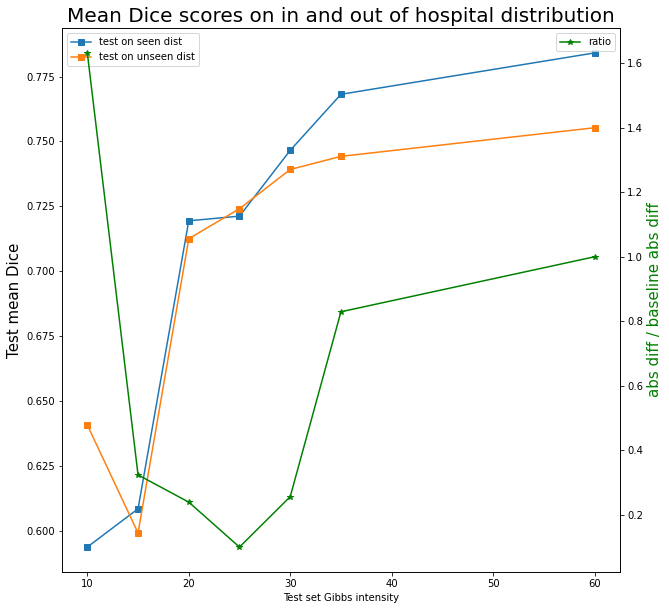

In [84]:
fig, ax1 = plt.subplots(figsize=(10,10))

ax1.set_xlabel('Test set Gibbs intensity')
ax1.set_ylabel('Test mean Dice',size =15)
ax1.plot([60,35,30,25,20,15,10],in_dist_perf, 's-', label='test on seen dist')
ax1.plot([60,35,30,25,20,15,10],out_dist_perf, 's-', label='test on unseen dist')
plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('abs diff / baseline abs diff', color='green', size=15)
ax2.plot([60,35,30,25,20,15,10],normalized_diffs, '*-',c='green', label='ratio')
plt.legend()
plt.title('Mean Dice scores on in and out of hospital distribution', size=20)
plt.show()